### Load packages

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from aste_helper_funcs import *
from ts2dte import ts2dte

# Read the Grid - do every time

### Define filenames and sizing

In [2]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirRun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirDiags = dirRun + "diags/"
dirState = dirDiags + "STATE/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [3]:
bigaste = True    # set up something to trigger in case we run with either big or little

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

### Define the Grid

In [4]:
mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','DXG','DYG'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    print(temp.shape)
    print(temp.reshape(nz, ny, nx).shape)
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

(50, 4050, 90)
(50, 1350, 270)


In [5]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)
# hf1 = hf1[np.newaxis,:, :]
hf1.shape

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

hf1 (1350, 270)
SZ! (1, 900, 540)
shape of fld: (1, 900, 540)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270) (1, 1350, 270)


In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

# 3d
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023
RAC2d (146614,)


In [7]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

# Make the DataSet

### Create a mask of the wet points for the rest of the data - compact shape

- iwetC2d should be iwetC3d - this should be based on hFacC. we want to set hFacC =1 where it is > 1
- can call this mskC
- hfacW and hfacS should be used when masking advective and diffusive fluxes
- we need get_aste_vector function somewhere

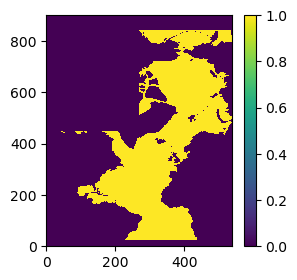

In [8]:
# 2D wet mask - this is wrong and only for the surface
wetmask = np.zeros((ny*nx))
wetmask[iwetC2d[np.where(hf2d>0)[0]]] = 1
wetmask =  np.reshape(wetmask,(ny,nx))
wetmaskplt = get_aste_tracer(wetmask,nfx,nfy)
# wetmaskplt = wetmaskplt.reshape(nfy[0]+nx+nfx[3],2*nx)
wetmaskplt = wetmaskplt.reshape(wetmaskplt.shape[1],wetmaskplt.shape[2])
plt.figure(figsize=(3,3))
plt.pcolormesh(wetmaskplt)
plt.colorbar()

In [9]:
# we havet to remake the wetmask using hFacC for 3D
wetmask = mygrid['hFacC']

### Read in the file - create xr

In [10]:
## note on timing and time averaging
# start with monthly average for 2014
# 1/1/2006 - 12/31/2011


'''
- we want mean volume dist. over this period (after individual calculations)
    - also interested in volume difference between months (m^3/s)
- start with heat flux budgeting (OceQnet)
- look for horizontal convergence
- advective and surface fluxes will be easiest to understand first
- tip: be vigilant with units
- find in the manual the naming convention of the time steps

'''

'\n- we want mean volume dist. over this period (after individual calculations)\n    - also interested in volume difference between months (m^3/s)\n- start with heat flux budgeting (OceQnet)\n- look for horizontal convergence\n- advective and surface fluxes will be easiest to understand first\n- tip: be vigilant with units\n- find in the manual the naming convention of the time steps\n\n'

In [11]:
# I think one file is __ time
fileTS = rdmds(dirState + "/state_3d_set1",4464)
fldListTS = parsemeta(dirState + "state_3d_set1.0000004464.meta")["fldList"]
print(fldListTS)
fileTS = fileTS.reshape(2,nz, ny, nx)
fileTS.shape  # compact form

['THETA', 'SALT']


(2, 50, 1350, 270)

In [12]:
# we want to mask our values with nan based on the wet points first- this will help with binning
wetmask[wetmask == 0] = np.nan

In [13]:
# remember that in order to plot this we have to use get_aste_tracer on the 1350 x 270 array
# this will give us the array that we can plot

In [14]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'T data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'S data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'ppt'}

In [15]:
temp = xr.DataArray(data = fileTS[0,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = fileTS[1,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [16]:
ds = xr.Dataset({'theta': temp, 'salinity': salt})

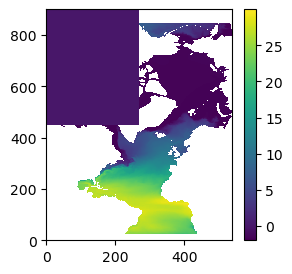

In [17]:
# test plot to make sure we are doing this correctly
fig = plt.figure(figsize=(3,3))
plt.pcolormesh(get_aste_tracer(temp[0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Grab the TS bins

In [18]:
# let's create a binning function with numpy
def bin_array(arr, bin_edges):
    flattened_arr = arr.flatten()
    bin_indices = np.digitize(flattened_arr, bin_edges)
    bin_indices_3d = bin_indices.reshape(arr.shape)
    
    return bin_indices_3d-1

In [19]:
# let's do a tester to make sure this function works - if these are the bin edges left and right inclusive, we would want to subtract 1
# ie if there are 10 bin edges, there are 9 bins, we want i-1
bins = np.arange(-1,10,1)
print(bins)
vals = np.array([0,0.3,.4,-0.2,3.3,3.8,2,8.9])
bin_array(vals,bins)

[-1  0  1  2  3  4  5  6  7  8  9]


array([1, 1, 1, 0, 4, 4, 3, 9])

In [20]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
# print(np.nanmin(binned_theta),np.nanmin(ds.theta.values),binsTH_edges[int(np.nanmin(binned_theta))])
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan        # not sure about this one
# print(np.nanmin(binned_salinity),np.nanmin(ds.salinity.values),binsSLT_edges[int(np.nanmin(binned_salinity))])

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [21]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

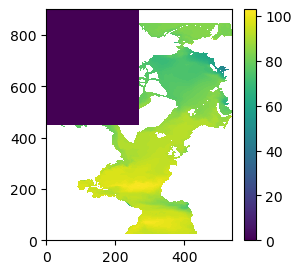

In [22]:
fig = plt.figure(figsize=(3,3))


plt.pcolormesh(get_aste_tracer(ds["salinity_binned"][0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Great, now we binned the values. Can we get the volume per cell?

In [23]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1,1)
dS = dS.reshape(112,112,1,1)

In [24]:
# the volume will just be based on the grid cell in the model
# we need the actual distance width, height, and depth of the model cells
# ALL IN COMPACT FORM, NEED get_aste_tracer(_, nfx,nfy) to plot
dxg = mygrid["DXG"]      # length on southern edge
dyg = mygrid["DYG"]     # length on eastern edge
depth = mygrid['Depth']    # compact form
hFacC = mygrid['hFacC']
drf = mygrid['DRF']        # depth between faces of cells

# reshape before multiplication
drf_expanded = drf[:,np.newaxis,np.newaxis]
cell_area = dxg*dyg

print(cell_area[np.newaxis,:,:].shape,drf_expanded.shape,hFacC.shape,dT.shape,dS.shape)   # check shapes

ffac=1e-6
cell_volume = cell_area[np.newaxis,:,:] * drf_expanded * hFacC * ffac    # width * heigh * area * fraction * ffac
print(cell_volume.shape)
print(binned_salt.shape,binned_temp.shape)

(1, 1350, 270) (50, 1, 1) (50, 1350, 270) (112, 112, 1, 1) (112, 112, 1, 1)
(50, 1350, 270)
(50, 1350, 270) (50, 1350, 270)


In [25]:
wetmask.shape

(50, 1350, 270)

In [26]:
cell_volume = cell_volume * wetmask[:,:,:]

In [27]:
binned_salt = binned_salt * wetmask[:,:,:]
binned_temp = binned_temp*wetmask[:,:,:]

In [28]:
testertemp = ds.theta.values
testersalt = ds.salinity.values

In [29]:
# Initialize mesh
starttime = time.time()

mesh = np.zeros((nS, nT, ny, nx))   # binsTH_edges-1

# Generate indices for valid wet points
valid_indices = np.where(~np.isnan(wetmask))


# # Iterate over all points in the domain
for i in range(ny):
    if i%250 == 0:
        print(i,"in",time.time()-starttime)
    for j in range(nx):
        thiscol = cell_volume[:, i, j]
        thissalt = binned_salt[:, i, j].values
        thistemp = binned_temp[:, i, j].values

        thiscol = thiscol[~np.isnan(thiscol)]
        thissalt = thissalt[~np.isnan(thissalt)].astype(int)
        thistemp = thistemp[~np.isnan(thistemp)].astype(int)

        # if not a dry point, add volume
        if len(thiscol)>0:
            mesh[thissalt,thistemp,i,j] += thiscol

mesh /= dT
mesh /= dS

0 in 0.10611104965209961
250 in 28.14892268180847
500 in 56.23416328430176
750 in 84.77374243736267
1000 in 111.63480138778687
1250 in 138.46455645561218


In [30]:
# add the mesh to the dataset
dims = ("i_Tbins","i_Sbins","compact_x","compact_y")
# not sure if we want the bin centers I think so 
coords = {"i_Tbins" : np.arange(0,nT,1),
          "i_Sbins" : np.arange(0,nS,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrs = {'title' : 'binned volume data within T and S bins for whole ASTE',
         'standard_name' : 'binnev volume',
         'units' : 'm^3/(deg C PSU)'}

In [31]:
# syntax
mesh2 = xr.DataArray(data = mesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrs)

In [32]:
ds["volume_mesh"] = mesh2

### Load the basins

In [33]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

In [34]:
# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [35]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)

ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [36]:
ds

<xarray.Dataset>
Dimensions:          (z: 50, compact_x: 1350, compact_y: 270, i_Tbins: 112,
                      i_Sbins: 112)
Coordinates:
  * z                (z) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * compact_x        (compact_x) int64 0 1 2 3 4 5 ... 1345 1346 1347 1348 1349
  * compact_y        (compact_y) int64 0 1 2 3 4 5 6 ... 264 265 266 267 268 269
  * i_Tbins          (i_Tbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
  * i_Sbins          (i_Sbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
Data variables:
    theta            (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity         (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    theta_binned     (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity_binned  (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    volume_mesh      (i_Tbins, i_Sbins, compact_x, compact_y) float64 0.0 ......
    mskBasin_3D      (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    mskBasin_2D      (compact_x, compact_y) float64 nan nan nan ... nan nan nan
    wetmask          (z, compact_x, compact_y) float64 nan nan nan ... nan nan

#### Option to save dataframe as netcdf

In [37]:
# path = "/home/mmurakami/crios_backups/ASTE_270"
# ds.to_netcdf(path + '/example.nc')

# Skip here if DataSet already made

In [38]:
# ds = xr.load_dataset("../example.nc")

### Plot for a specific Basin - ie BarentsS

In [39]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = mpl.cm.get_cmap("viridis",14).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

/tmp/ipykernel_2113925/3075689644.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis",14).copy()


In [40]:
# for a tester basin we want to use 2D because of the shape of the volume array
volume_test = ds['volume_mesh'].values

In [41]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [45]:
# add the rho lines
# add the polygons and the points
smin = 26 - (0.01 * 26)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2.5 + (0.1 * -2.5)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 7.5 + (0.1 * 7.5)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2.5,7.5,ydim)
si = np.linspace(26,36,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

# convert to practical/potential - ask An if we need to do this? What model output?
# long = 73.5089
# lat = -66.8245
# ti = gsw.pt_from_CT(si1,ti1)
# si = gsw.SP_from_SA(si1,0,long,lat)

tmin, tmax, smin, smax sizes=, -2.75 8.25 25.74 36.36


/tmp/ipykernel_2113925/2467002750.py:20: RuntimeWarning: divide by zero encountered in log10
  cb = ax.pcolormesh(Sbin,Tbin,np.log10(test_vol),zorder=3)


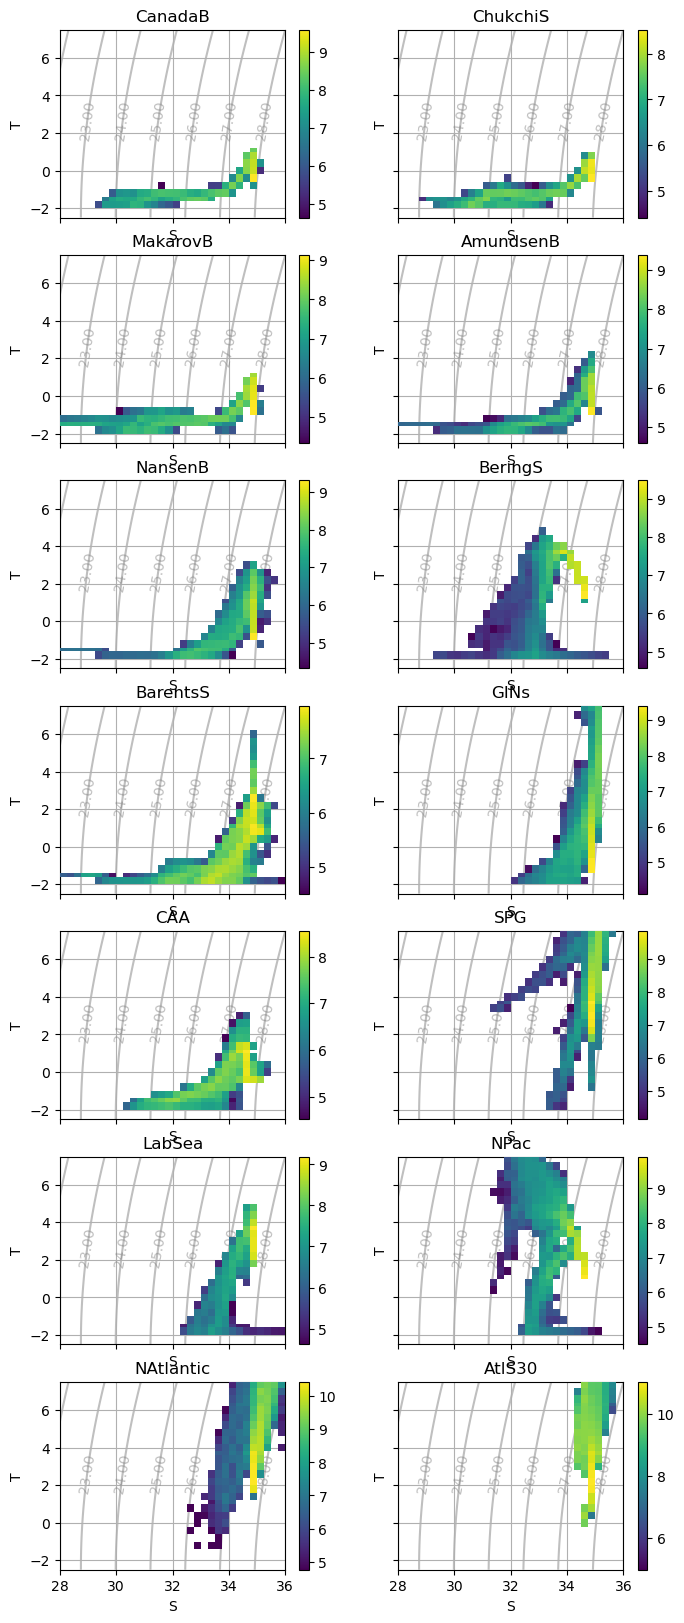

In [46]:
# plt.figure(figsize = (5,5))
num_plots = strb.shape[0]
rows = 7
cols = 2
fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(8,20))
if num_plots>1:
    axes = axes.flatten()
    
for i in range(len(strb)):
    ax = axes[i]

    # add isopycnals
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(22,29,1))
    cl=ax.clabel(cs,fontsize=10,inline=False,fmt="%.2f")

    # add volume distribution
    title = strb[i]
    test_vol = volume_test[:,:,mskBasin==i]
    test_vol = np.nansum(test_vol,axis=2)
    cb = ax.pcolormesh(Sbin,Tbin,np.log10(test_vol),zorder=3)

    # labels
    fig.colorbar(cb)
    ax.set_title(title)
    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.grid()
    ax.set_xlim(28,36)
    ax.set_ylim(-2.5,7.5)

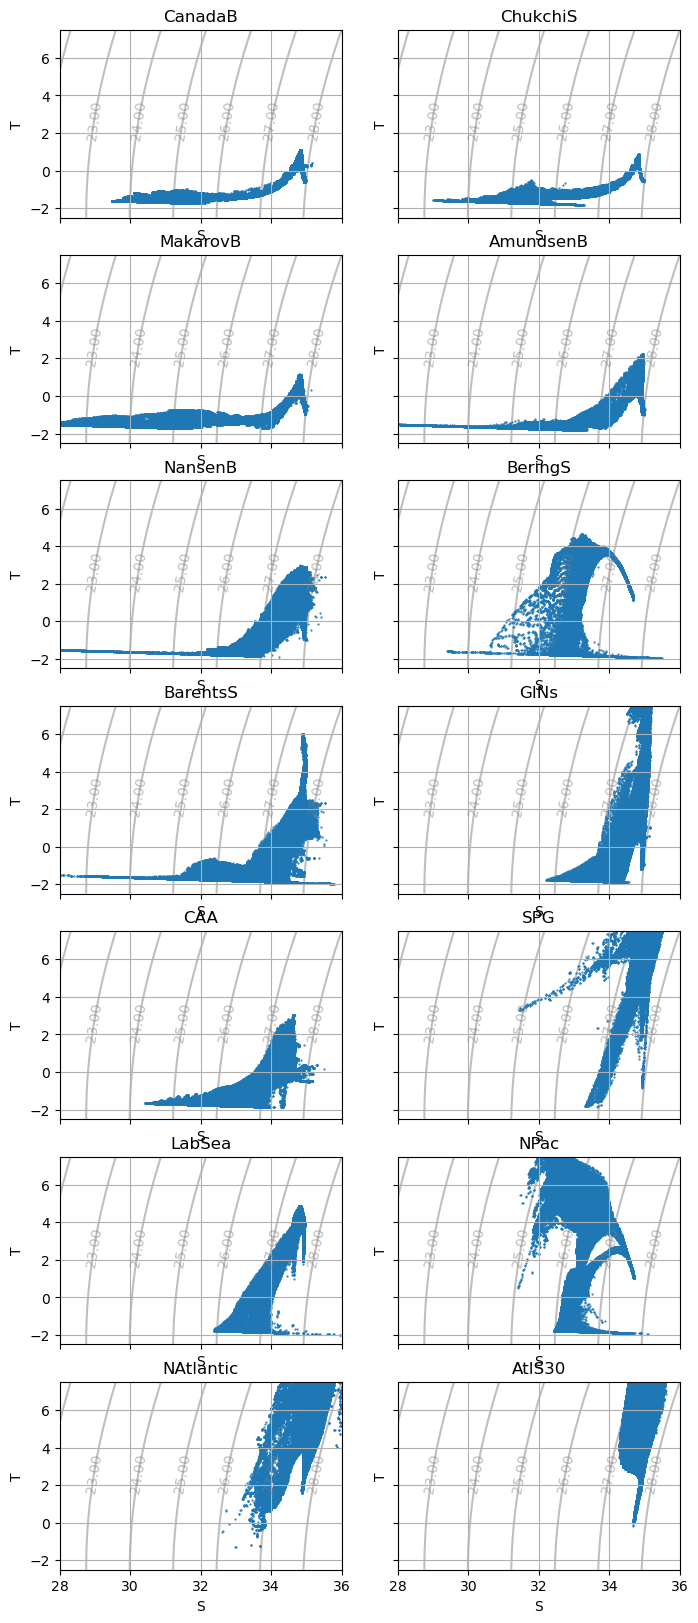

In [47]:
# do a verification scatter plot with the original data we read at the beginning
num_plots = strb.shape[0]
rows = 7
cols = 2
fig,axes = plt.subplots(rows,cols,sharex=True, sharey=True,figsize=(8,20))
if num_plots>1:
    axes = axes.flatten()
    
for i in range(len(strb)):
    ax = axes[i]

    # add isopycnals
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(22,29,1))
    cl=ax.clabel(cs,fontsize=10,inline=False,fmt="%.2f")

    # add the scatter
    title = strb[i]
    testt = ds.theta.values[mskBasin_3D.values == i]
    tests = ds.salinity.values[mskBasin_3D.values == i]
    ax.scatter(tests,testt,s=0.3,marker="o")

    # add labels
    ax.set_title(title)
    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.grid()
    ax.set_xlim(28,36)
    ax.set_ylim(-2.5,7.5)

### Let's try to look at a depth section from the Gateways

In [48]:
# first define the gateways
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])
    ggate  = inf['ggate']
    ggate2  = inf['ggate2']

# print to get some context
num = 1
for i in ggate[0]:
    label = i[0][0][0]
    print(num,label)
    num += 1
print()

num = 1
for i in ggate2[0]:
    label = (i[0][0][-2])
    print(num,label)
    num += 1

1 ['FramStrait']
2 ['NaresStrait']
3 ['CAA']
4 ['BarrowStrait/LancasterSound']
5 ['BarentsSeaOpening']
6 ['Svalbard-FranzJosefIslands']
7 ['FranzJosefIslands-NovayaZemlya']
8 ['KaraStrait']
9 ['StAnnaTrough/Voronin/Vilkitshogo']
10 ['BeringStrait']
11 ['DenmarkStrait']
12 ['Iceland-FaroeI']
13 ['Faroe-Shetland']
14 ['GibraltarStrait']
15 ['DavisStrait']
16 ['FloridaStrait']
17 ['BeringSea']
18 ['SubPolarGyre']
19 ['LabradorSea']

1 ['NansenAmundsen']
2 ['AmundsenMakarov']
3 ['MakarovCBCK']
4 ['FramStraitNansen']
5 ['FramStraitAmundsen']
6 ['NaresStraitMakarov']
7 ['OSNAPeast']


In [49]:
# we have to first make a dictionary
gg = {}
ggate1 = ggate[0]
for mygate in ggate1:
    name = mygate[0][0][0][0]
    gg[name] = {}
    gg[name]['ix'] = mygate[0][0][1][0]
    gg[name]['jy'] = mygate[0][0][2][0]
    gg[name]['signu'] = mygate[0][0][3][0]
    gg[name]['signv'] = mygate[0][0][4][0]
    gg[name]['descr'] = mygate[0][0][5][0]

In [50]:
gg2 = {}
ggate2a = ggate2[0]
for mygate in ggate2a:
    name = mygate[0][0][4][0]
    gg2[name] = {}
    gg2[name]['ix'] = mygate[0][0][0][0]
    gg2[name]['jy'] = mygate[0][0][1][0]
    gg2[name]['signu'] = mygate[0][0][2][0]
    gg2[name]['signv'] = mygate[0][0][3][0]
    gg2[name]['descr'] = mygate[0][0][5][0]

In [51]:
# check with An to see if these are the same values
for igate in gg.keys():
    L = len(gg[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg[igate]['jy'][i] - 1) * nx + gg[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg[igate]['indwet'] = indwet
    gg[igate]['ivalid'] = ivalid

In [52]:
# check with An to see if these are the same values
for igate in gg2.keys():
    L = len(gg2[igate]['ix'])
    ivalid = np.zeros(L)
    ind = np.empty(L)
    ind.fill(np.nan)
    indwet = np.empty(L)   # same as ind
    indwet.fill(np.nan)
    for i in range(L):
        ind[i] = (gg2[igate]['jy'][i] - 1) * nx + gg2[igate]['ix'][i]
        # It is quite possible some of the [ix,jy] were on land,
        # which means it would not show up in iwet2d.full:
        ii = np.where(iwetC2d == ind[i])[0]
        if len(ii) > 0:
            indwet[i] = ii[0]
            ivalid[i] = 1
        else:
            indwet[i] = np.nan

    # set it in the dictionary under the basin name
    gg2[igate]['indwet'] = indwet
    gg2[igate]['ivalid'] = ivalid

In [53]:
# we should try and plot these to make sure I'm doing this correctly
# create a mask for the gateways
mskGate_gg = np.full((ny,nx),np.nan)

num = 1
for igate in gg.keys():
    ix = (gg[igate]['ix']) - 1   # for python translation
    jy = (gg[igate]['jy']) - 1   # for python translation from matlab

    mskGate_gg[jy,ix] = num      # label the basin as printed above
    num += 1

In [54]:
mskGate_gg2 = np.full((ny,nx),np.nan)

num = 1
for igate in gg2.keys():
    ix = (gg2[igate]['ix']) - 1   # for python translation
    jy = (gg2[igate]['jy']) - 1   # for python translation from matlab

    mskGate_gg2[jy,ix] = num
    num += 1

# we can multiply by mskGate_2D to get the wet array
test = mskGate_gg * ds["wetmask"].values[0]
np.nansum(test-mskGate_gg)

0.0

### Add in the vectors from file

In [55]:
meta=parsemeta(dirDiags + "TRSP/trsp_2d_set1.0000438048.meta")
fldList = meta["fldList"]
desiredflds = ["ADVx_TH","ADVy_TH"]
print(fldList)
recs = [fldList.index(item) for item in desiredflds if item in fldList]    # get the record numbers for rdmds
print(recs)

['DFxE_TH', 'DFyE_TH', 'ADVx_TH', 'ADVy_TH', 'DFxE_SLT', 'DFyE_SLT', 'ADVx_SLT', 'ADVy_SLT']
[2, 3]


In [56]:
u = rdmds(dirDiags + "TRSP/" + "trsp_2d_set1",438048,rec = recs[0])      # 4050 x 90
u = u.reshape(ny,nx)                                                     # 1350 x 270

v = rdmds(dirDiags + "TRSP/" + "trsp_2d_set1",438048,rec = recs[1])      # 4050 x 90
v = v.reshape(ny,nx)                                                     # 1350 x 270

In [57]:
# we might need create rebinned arrays of the u and v values
fldstr3d = ['hFacW','hFacS']

for fld in fldstr3d:
    Fac_fld = rdmds(os.path.join(dirgrid, fldstr3d[fldstr3d.index(fld)]))
    print(Fac_fld.reshape(nz, ny, nx).shape)
    mygrid[fld] = Fac_fld.reshape(nz, ny, nx)                            # 50 x 1350 x 270

(50, 1350, 270)
(50, 1350, 270)
